## Using SHAP for interpretability

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dotenv import load_dotenv
import os
import numpy as np


from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

import xgboost as xgb
from ngboost import NGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge

import pickle
import shap
shap.initjs()

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Import dataset
load_dotenv()
# Load X and y splits
x_train_path = os.getenv("X_TRAIN_MERGED_SCALED")
x_test_path  = os.getenv("X_TEST_MERGED_SCALED")
y_train_path = os.getenv("Y_TRAIN_MERGED_SCALED")
y_test_path  = os.getenv("Y_TEST_MERGED_SCALED")

X_train = pd.read_csv(x_train_path)
X_test  = pd.read_csv(x_test_path)
y_train = pd.read_csv(y_train_path)
y_test  = pd.read_csv(y_test_path)

# Optional: quick check
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(875, 23) (875, 1)
(376, 23) (376, 1)


In [5]:
imputer_nonLin = IterativeImputer(
    estimator=BayesianRidge(),
    random_state=42,
)

imputer_nonLin.fit(X_train)
X_train_missForest = imputer_nonLin.transform(X_train)
X_test_missForest = imputer_nonLin.transform(X_test)

In [6]:
X_train_knn_t = pd.DataFrame(
    X_train_missForest, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_missForest, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [7]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [8]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((875, 23), (376, 23))

In [9]:
sel = ['RID', 'Gender', 'Ageatscreening', 'MMSE0m', 'HipsASMbaseline',
       'HipsContrastbaseline', 'HipsCorelationbaseline',
       'HipsSumAveragebaseline', 'HipsSumVariancebaseline',
       'HipsEntropybaseline', 'ERCsASMbaseline', 'ERCsContrastbaseline',
       'ERCsVariancebaseline', 'ERCsSumVariancebaseline',
       'ERCsEntropybaseline', 'ERCsClusterShadebaseline',
       'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'HipposcampusVolumebaseline']

In [10]:
selected_features = [col for col in sel if col in X_train_t.columns]
selected_features

['RID',
 'Gender',
 'Ageatscreening',
 'MMSE0m',
 'HipsASMbaseline',
 'HipsContrastbaseline',
 'HipsCorelationbaseline',
 'HipsSumAveragebaseline',
 'HipsSumVariancebaseline',
 'HipsEntropybaseline',
 'ERCsASMbaseline',
 'ERCsContrastbaseline',
 'ERCsVariancebaseline',
 'ERCsSumVariancebaseline',
 'ERCsEntropybaseline',
 'ERCsClusterShadebaseline',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline',
 'HipposcampusVolumebaseline']

In [11]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((875, 19), (376, 19))

In [17]:
with open("rf_model.pkl", "rb") as file:
    loaded_model_rf = pickle.load(file)
print(f"{loaded_model_rf} model loaded successfully!\n")

with open("xgboost_model.pkl", "rb") as file:
    loaded_model_xgb = pickle.load(file)
print(f"{loaded_model_xgb} model loaded successfully!\n")


with open("ngboost_model.pkl", "rb") as file:
    loaded_model_ngb = pickle.load(file)
print(f"{loaded_model_ngb} model loaded successfully!")

with open("logit_model.pkl", "rb") as file:
    loaded_model_logit = pickle.load(file)
print(f"{loaded_model_logit} model loaded successfully!")

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=11, max_features=None,
                       min_samples_leaf=0.015434035082414447,
                       min_samples_split=0.04569944912071945, n_estimators=227,
                       random_state=42) model loaded successfully!

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9221482020702703, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.7628004262927874,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1290179023309051,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, mon

In [13]:
# Compute SHAP values for Random Forest
explainer_rf = shap.TreeExplainer(loaded_model_rf)
shap_values_rf = explainer_rf.shap_values(X_test_t)

: 

In [ ]:
# Compute SHAP values for XGBoost
explainer_xgb = shap.TreeExplainer(loaded_model_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test_t)

In [ ]:
# Compute SHAP values for NGBoost
explainer_ngb = shap.Explainer(loaded_model_ngb.predict_proba, X_test_t)
shap_values_ngb = explainer_ngb(X_test_t)


PermutationExplainer explainer: 377it [35:57,  5.74s/it]                         


In [18]:
# Compute SHAP values for Logistic Regression
explainer_logit = shap.LinearExplainer(loaded_model_logit, X_test_t)
shap_values_logit = explainer_logit.shap_values(X_test_t)

In [16]:
# Random Forest
print("Random Forest number of features:", loaded_model_rf.n_features_in_)

# XGBoost
print("XGBoost number of features:", loaded_model_xgb.n_features_in_)

# NGBoost

# Logistic Regression
print("Logistic Regression number of features:", loaded_model_logit.coef_.shape[1])


Random Forest number of features: 23
XGBoost number of features: 23
Logistic Regression number of features: 23


In [ ]:
print(shap_values_rf.shape)
print(shap_values_xgb.shape)
print(shap_values_ngb.shape)
print(shap_values_logit.shape)

(376, 22, 3)
(376, 22, 3)
(376, 22, 3)
(376, 22, 3)


## Global interpretability

C:\Users\steve\AppData\Local\Temp\ipykernel_10772\804790303.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf, X_test_t, feature_names=X_test_t.columns, plot_type="bar")


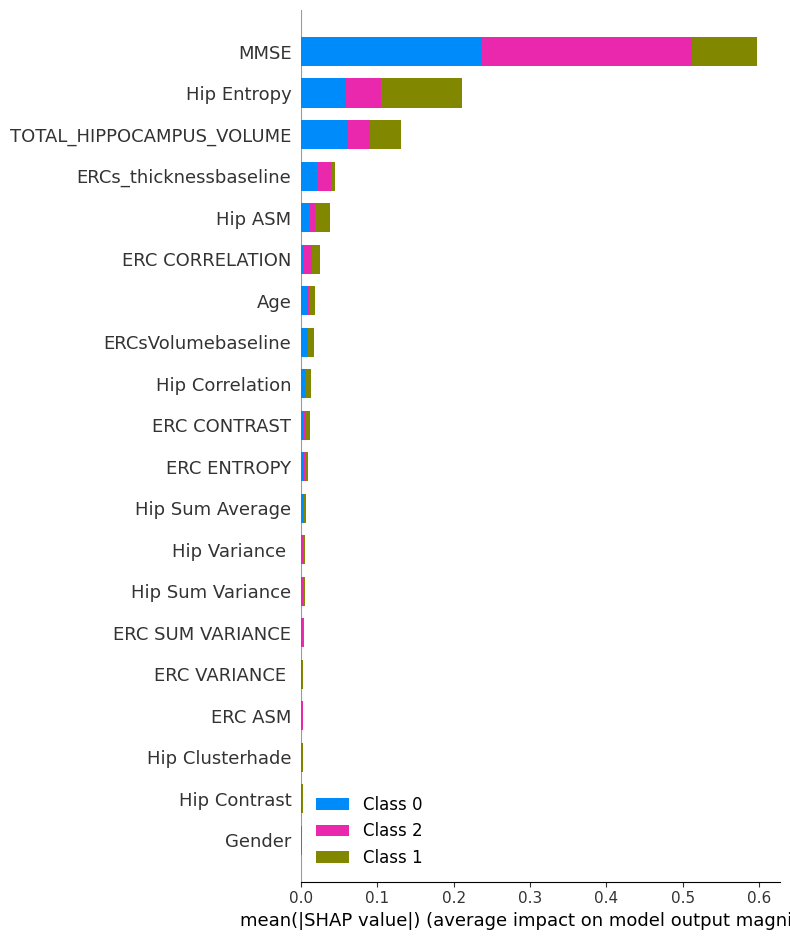

C:\Users\steve\AppData\Local\Temp\ipykernel_10772\804790303.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb, X_test_t, feature_names=X_test_t.columns, plot_type="bar")


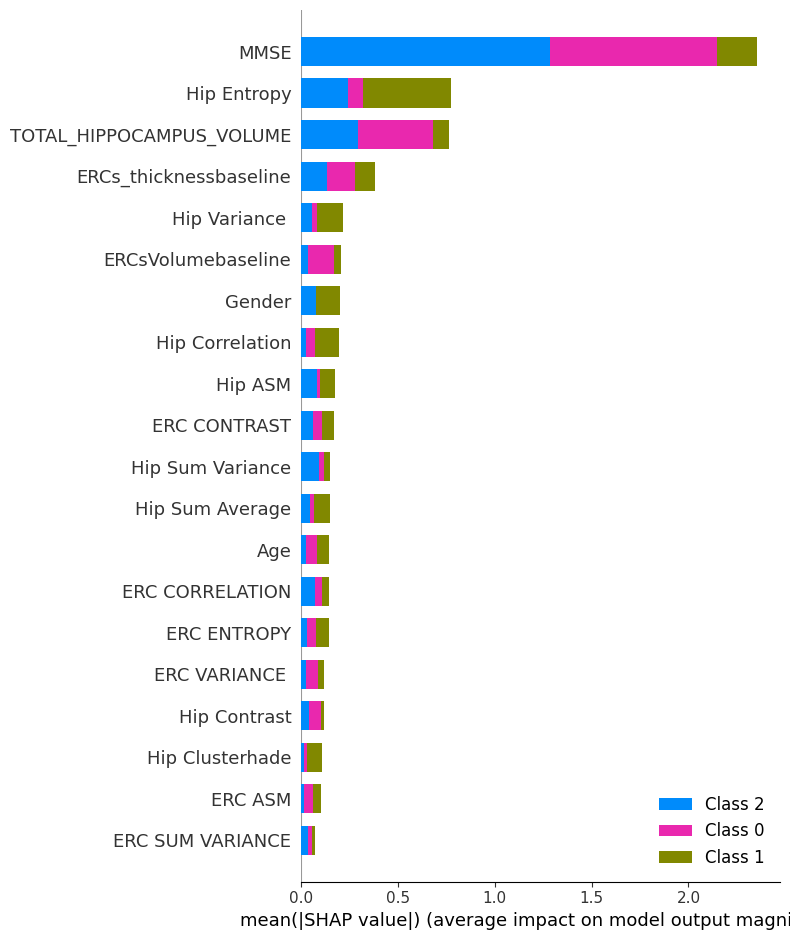

C:\Users\steve\AppData\Local\Temp\ipykernel_10772\804790303.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_ngb.values, X_test_t, feature_names=X_test_t.columns, plot_type="bar")


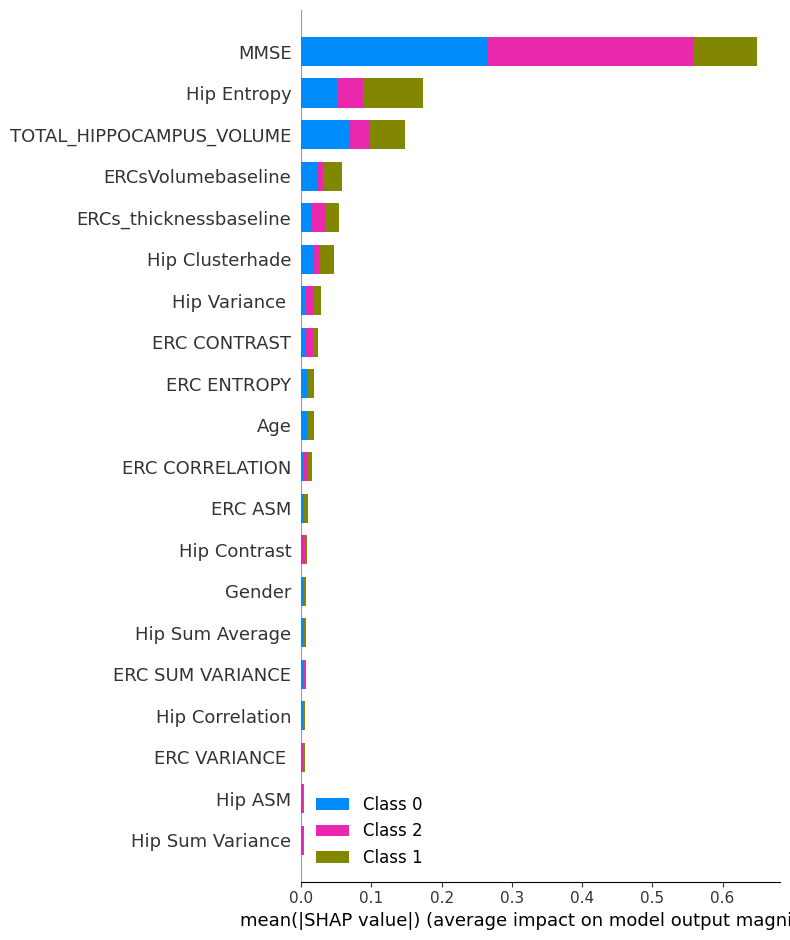

C:\Users\steve\AppData\Local\Temp\ipykernel_10772\804790303.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_logit, X_test_t, feature_names=X_test_t.columns, plot_type="bar")


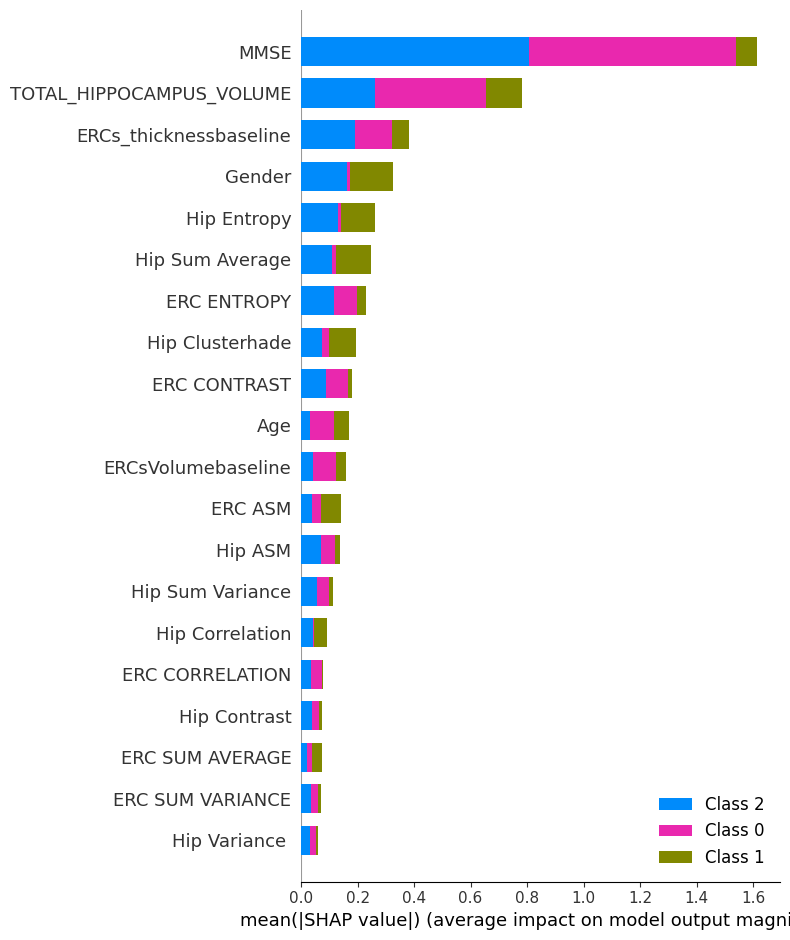

In [ ]:
# Beeswarm plots
shap.summary_plot(shap_values_rf, X_test_t, feature_names=X_test_t.columns, plot_type="bar")
shap.summary_plot(shap_values_xgb, X_test_t, feature_names=X_test_t.columns, plot_type="bar")
shap.summary_plot(shap_values_ngb.values, X_test_t, feature_names=X_test_t.columns, plot_type="bar")
shap.summary_plot(shap_values_logit, X_test_t, feature_names=X_test_t.columns, plot_type="bar")

## Local interpretability

In [ ]:
## SHAP plot for loc trees
explainer_rf = shap.TreeExplainer(loaded_model_rf) 
shap_values_rf = explainer_rf.shap_values(X_test_t)

print(shap_values_rf.shape)
print(explainer_rf.expected_value)

(376, 22, 3)
[0.33479585 0.33370063 0.33150352]


In [ ]:
# Force plot for the first instance
shap.force_plot(explainer_rf.expected_value[0], shap_values_rf[0, :, 1], X_test_t.iloc[0, :], feature_names=X_test_t.columns)

SHAP Beeswarm Plot for Class 0


C:\Users\steve\AppData\Local\Temp\ipykernel_10772\3528881374.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


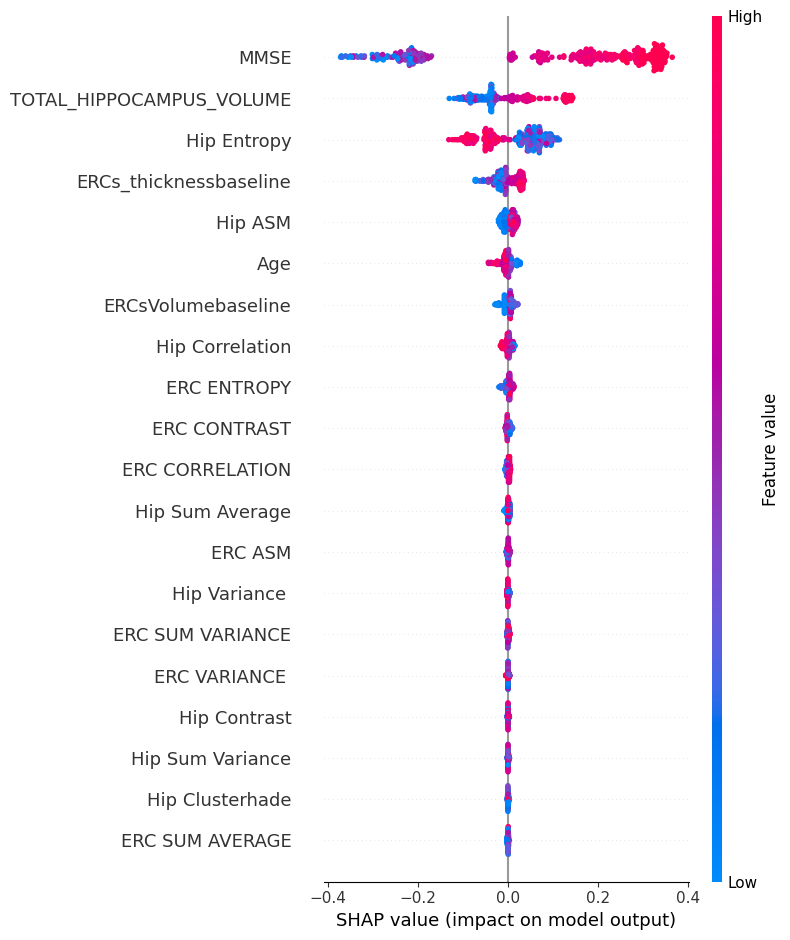

C:\Users\steve\AppData\Local\Temp\ipykernel_10772\3528881374.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


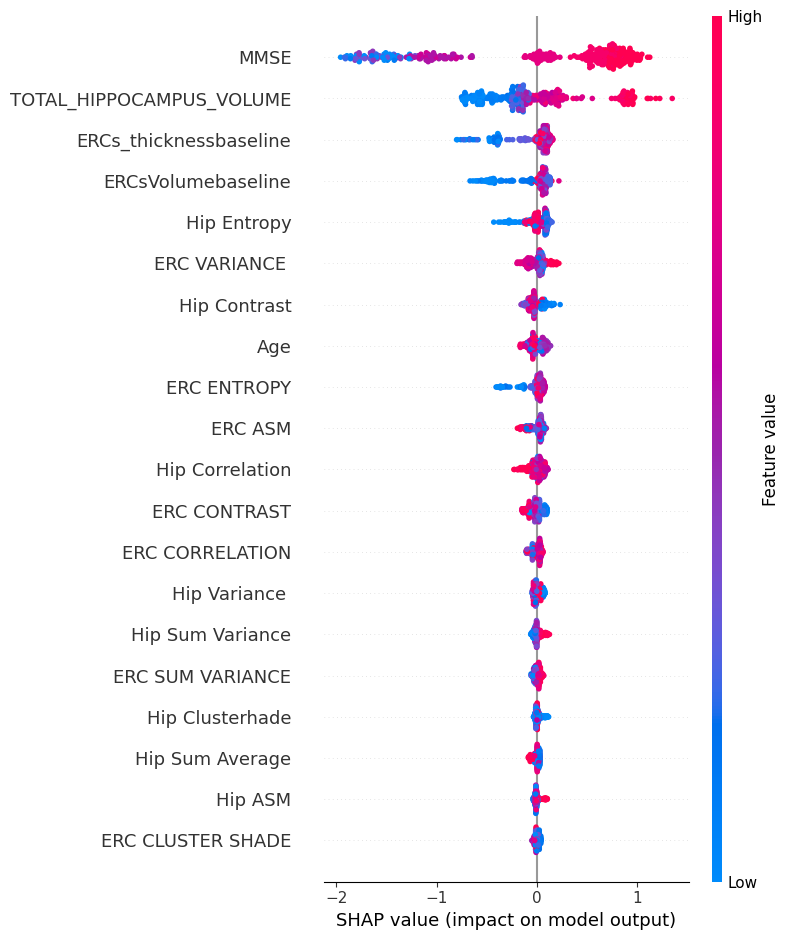

C:\Users\steve\AppData\Local\Temp\ipykernel_10772\3528881374.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_ngb.values[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


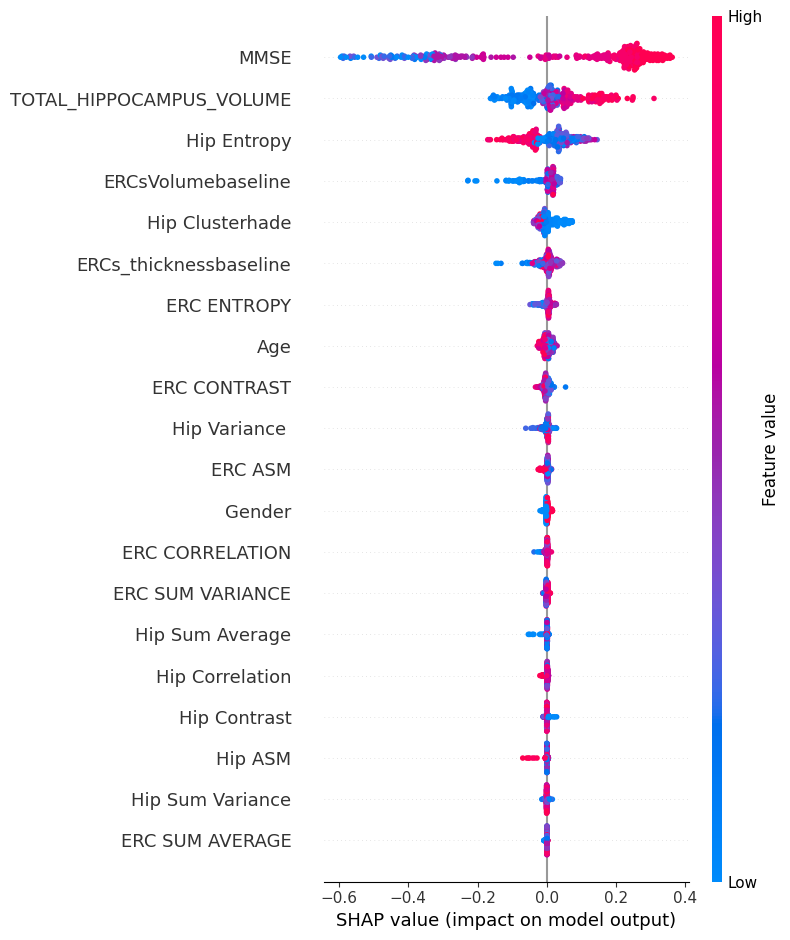

C:\Users\steve\AppData\Local\Temp\ipykernel_10772\3528881374.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_logit[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


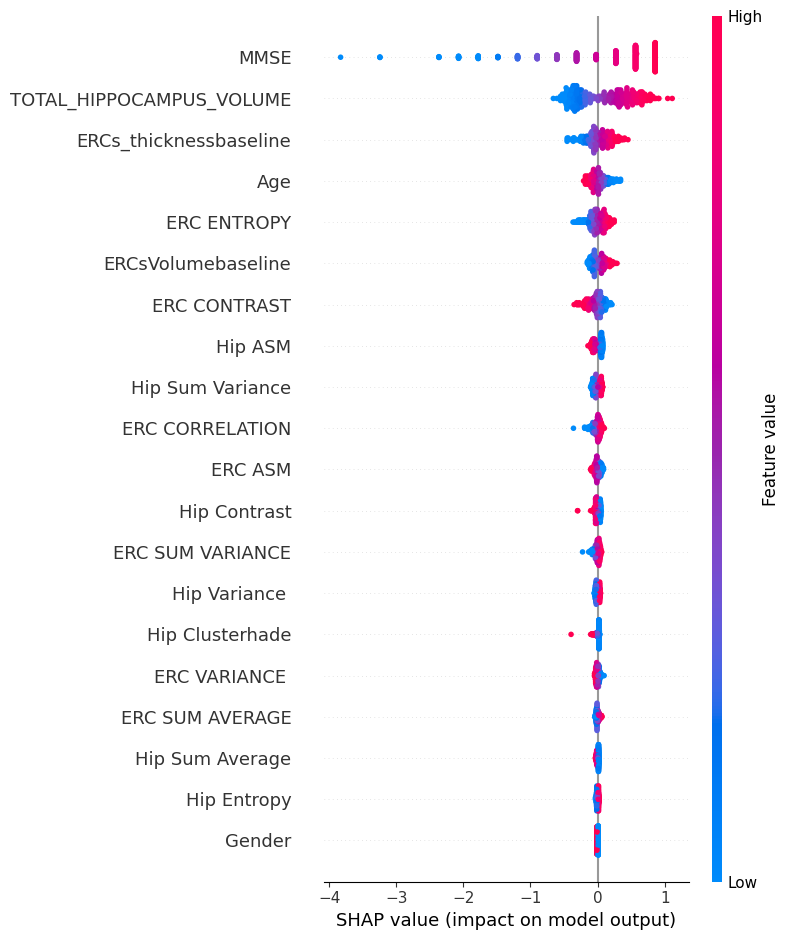

SHAP Beeswarm Plot for Class 1


C:\Users\steve\AppData\Local\Temp\ipykernel_10772\3528881374.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


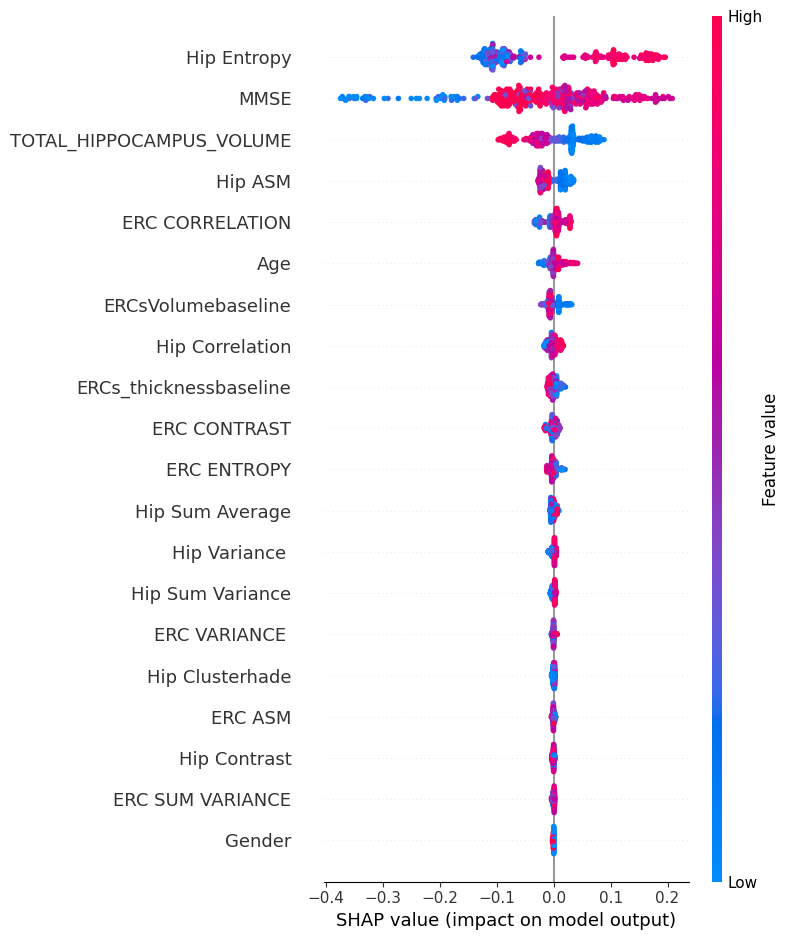

C:\Users\steve\AppData\Local\Temp\ipykernel_10772\3528881374.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


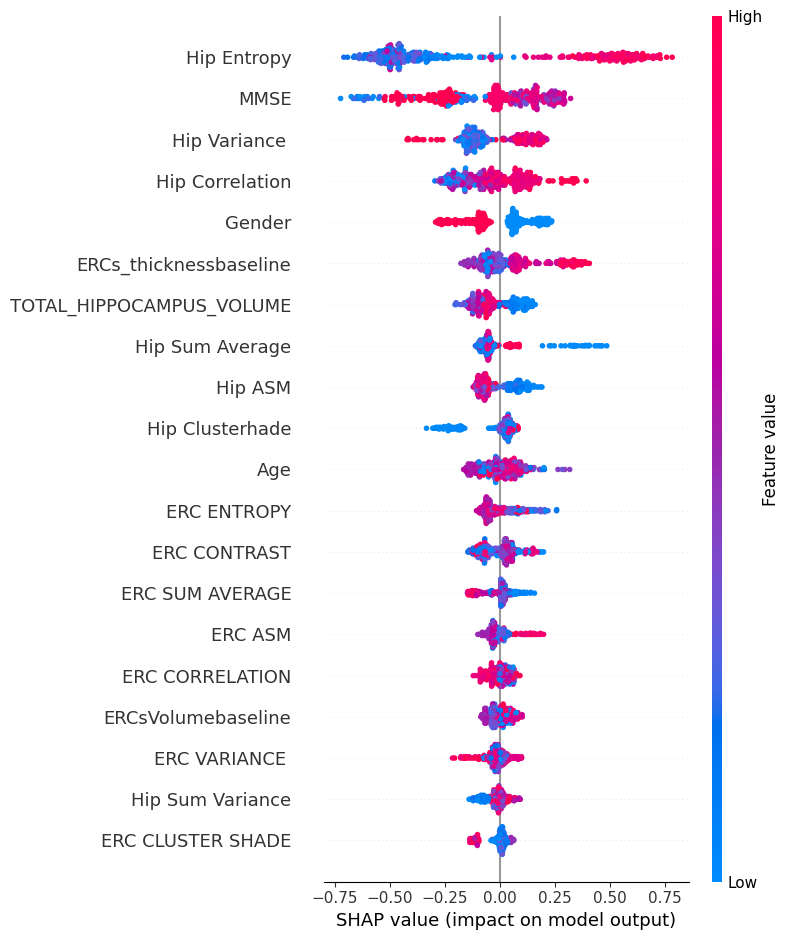

C:\Users\steve\AppData\Local\Temp\ipykernel_10772\3528881374.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_ngb.values[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


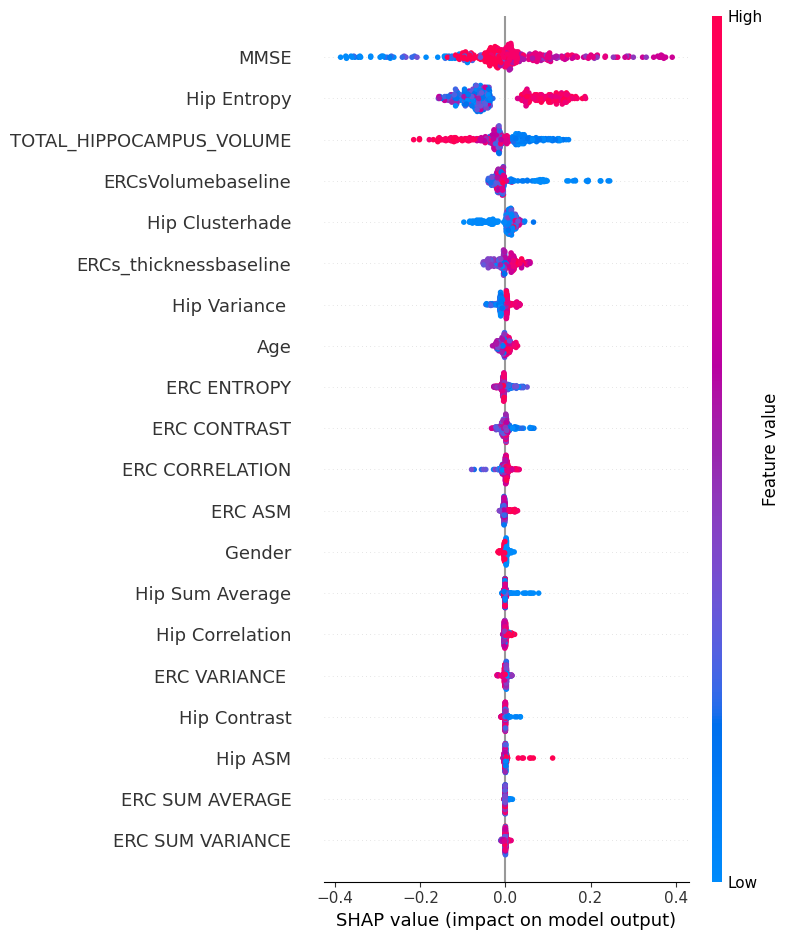

C:\Users\steve\AppData\Local\Temp\ipykernel_10772\3528881374.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_logit[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


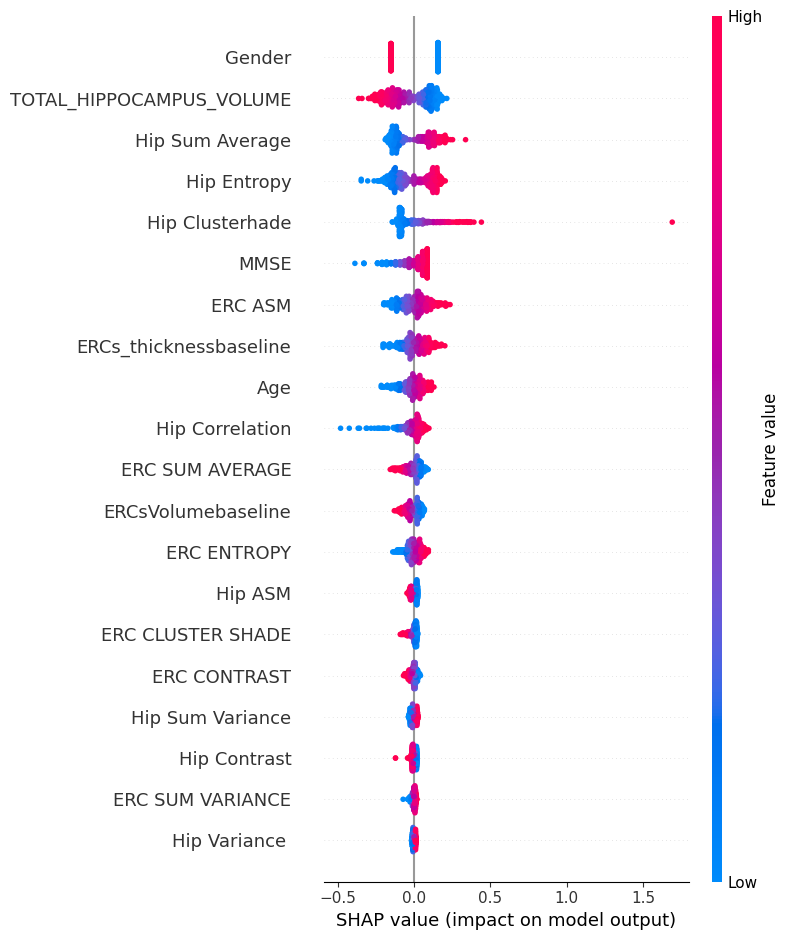

SHAP Beeswarm Plot for Class 2


C:\Users\steve\AppData\Local\Temp\ipykernel_10772\3528881374.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


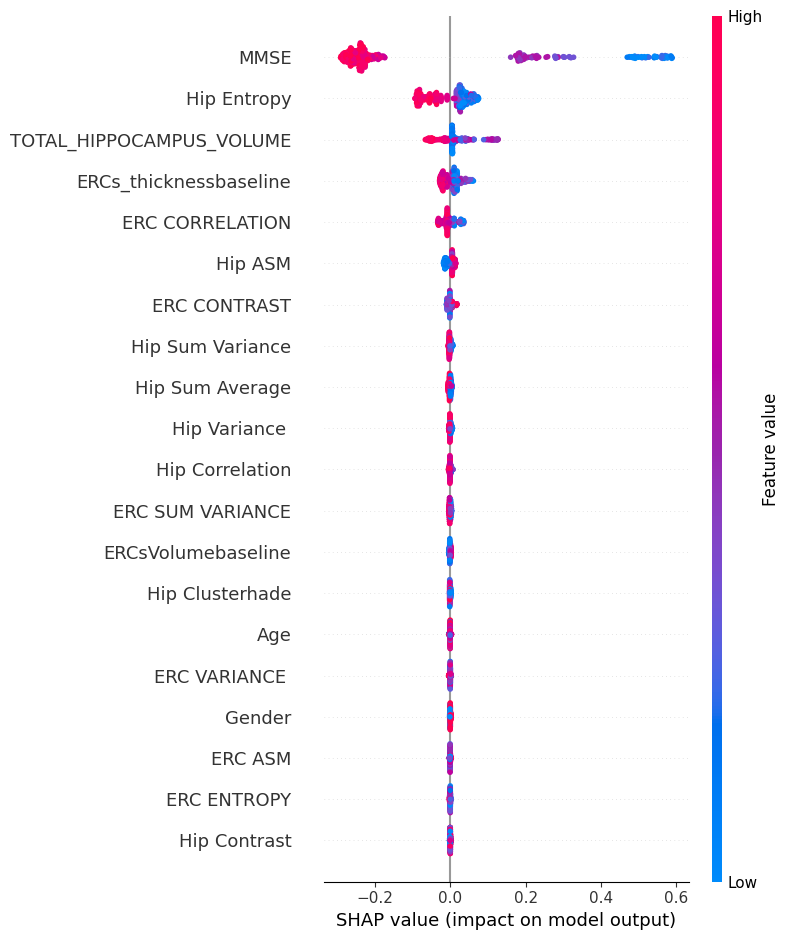

C:\Users\steve\AppData\Local\Temp\ipykernel_10772\3528881374.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


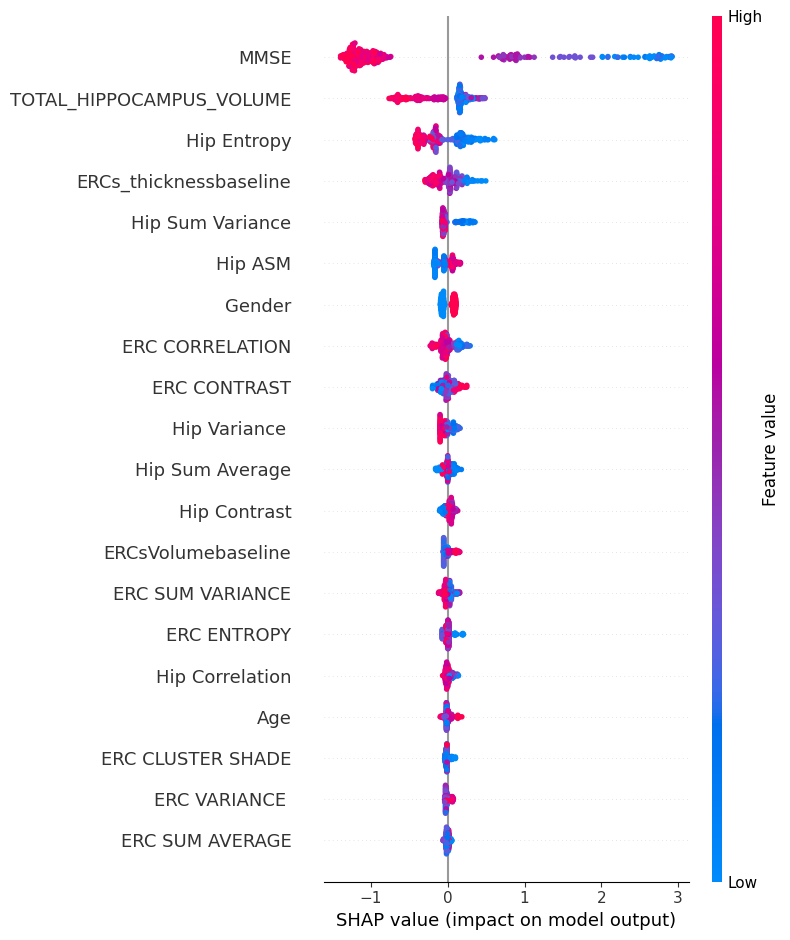

C:\Users\steve\AppData\Local\Temp\ipykernel_10772\3528881374.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_ngb.values[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


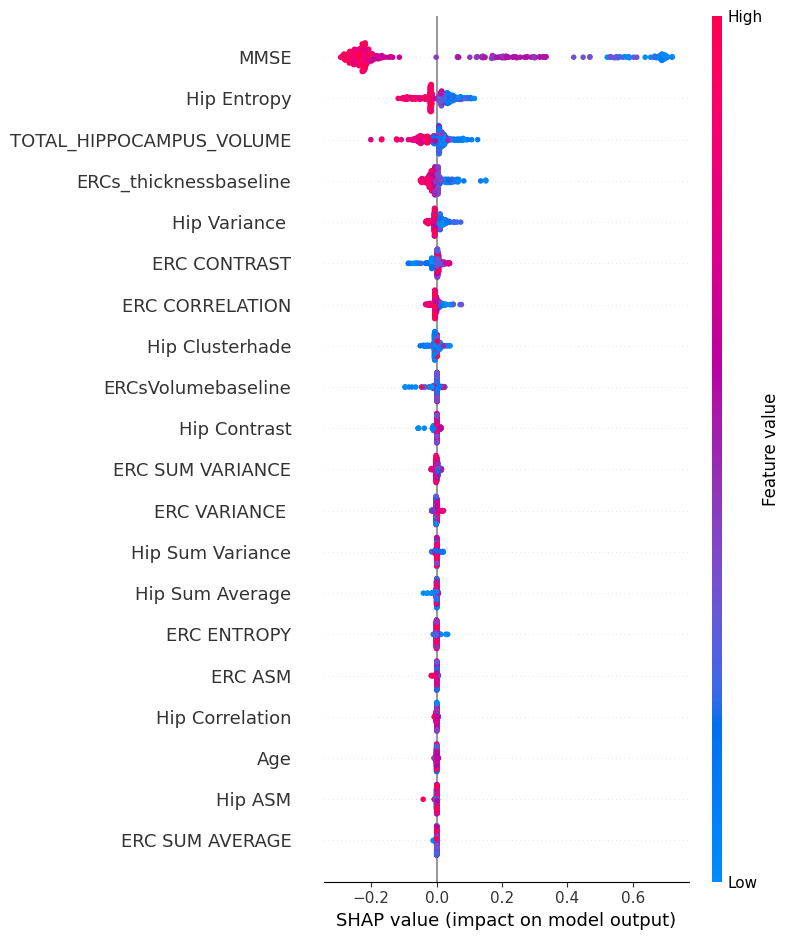

C:\Users\steve\AppData\Local\Temp\ipykernel_10772\3528881374.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_logit[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


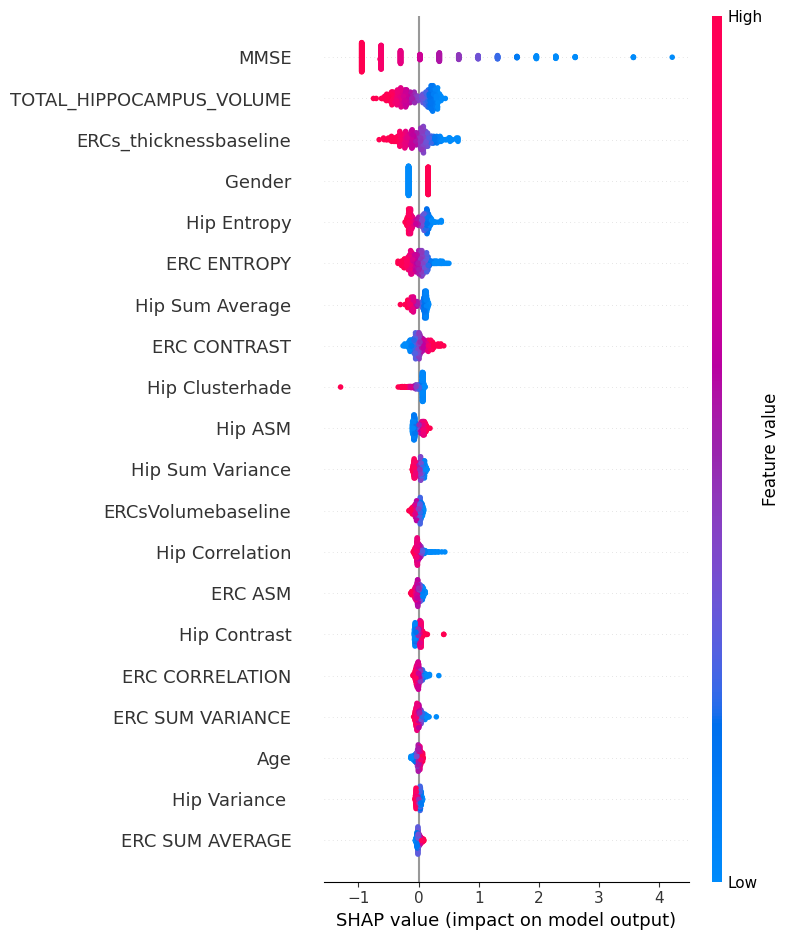

In [ ]:
# Plot SHAP beeswarm for each class
for class_idx in range(shap_values_rf.shape[2]):  # Loop over each class
    print(f"SHAP Beeswarm Plot for Class {class_idx}")

    # Random Forest
    shap.summary_plot(shap_values_rf[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)

    # XGBoost
    shap.summary_plot(shap_values_xgb[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)

    # NGBoost
    shap.summary_plot(shap_values_ngb.values[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)
    
    # Logistic
    shap.summary_plot(shap_values_logit[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


C:\Users\steve\AppData\Local\Temp\ipykernel_10772\1301353166.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf_mean, X_test_t, feature_names=X_test_t.columns)


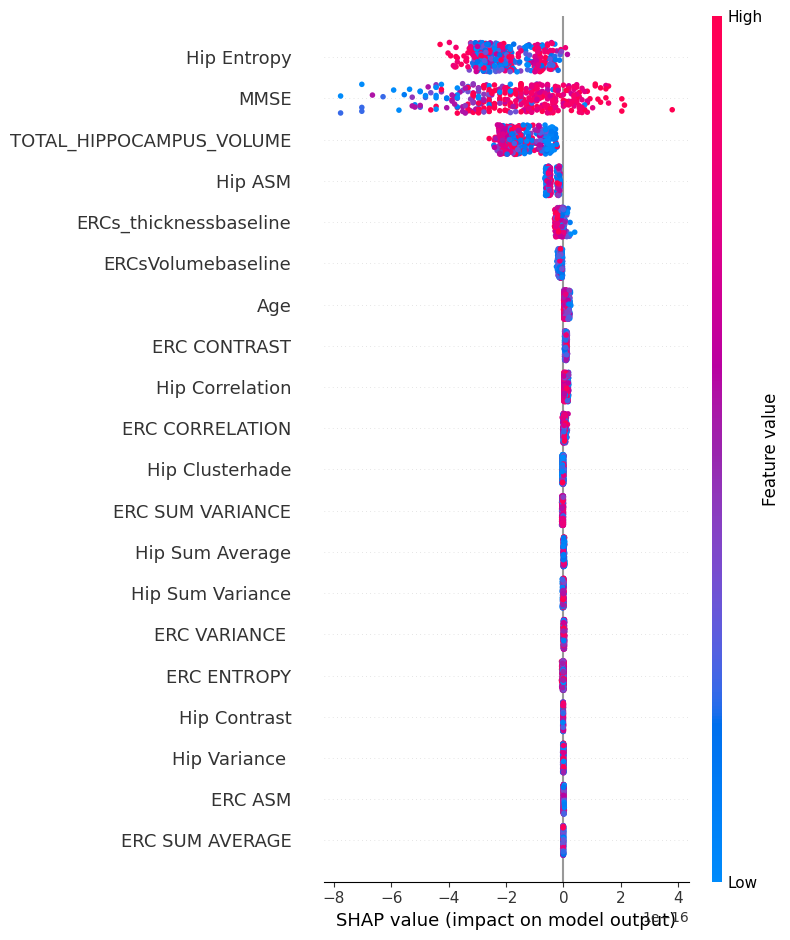

C:\Users\steve\AppData\Local\Temp\ipykernel_10772\1301353166.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb_mean, X_test_t, feature_names=X_test_t.columns)


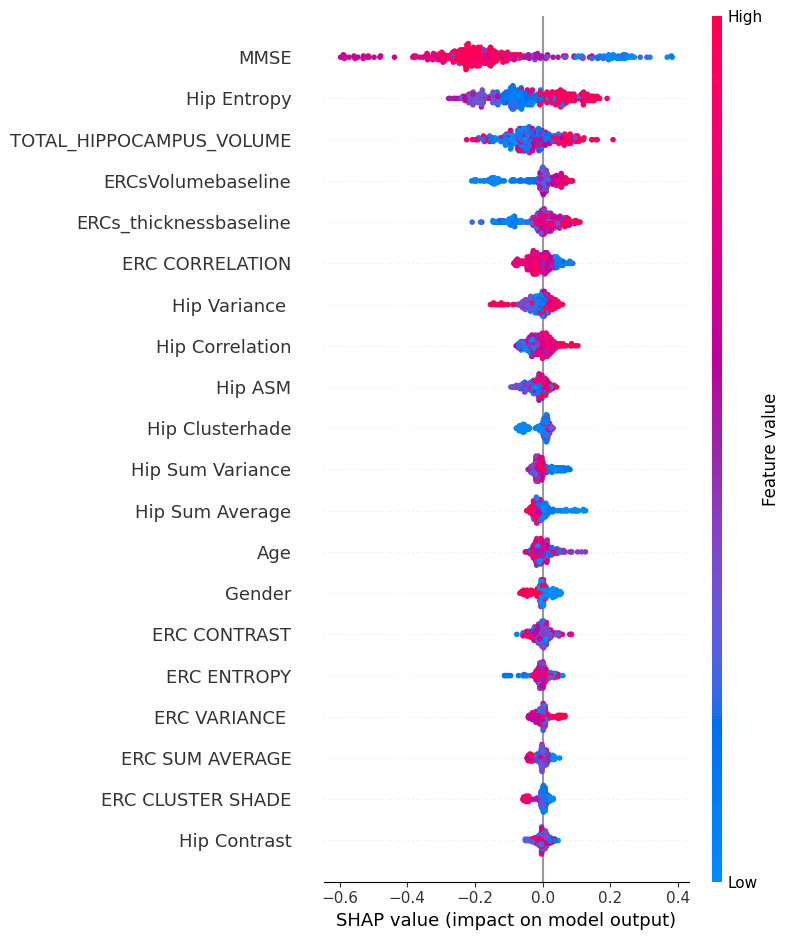

C:\Users\steve\AppData\Local\Temp\ipykernel_10772\1301353166.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_ngb_mean, X_test_t, feature_names=X_test_t.columns)


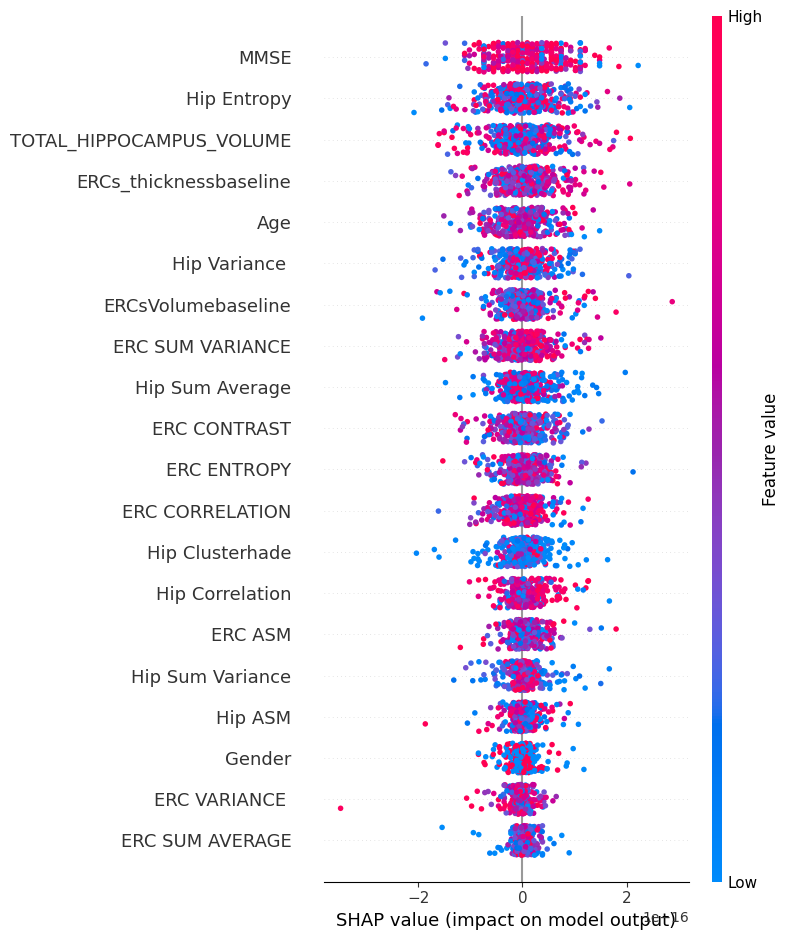

C:\Users\steve\AppData\Local\Temp\ipykernel_10772\1301353166.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_logit_mean, X_test_t, feature_names=X_test_t.columns)


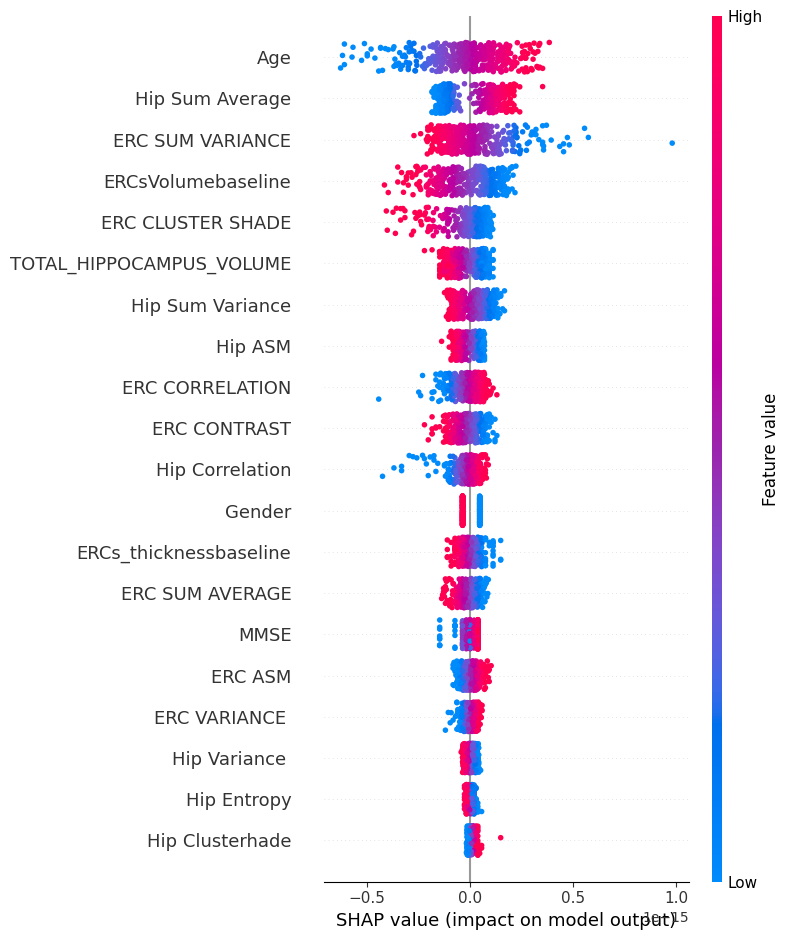

In [ ]:
shap_values_rf_mean = shap_values_rf.mean(axis=2)  # Average over classes
shap_values_xgb_mean = shap_values_xgb.mean(axis=2)
shap_values_ngb_mean = shap_values_ngb.values.mean(axis=2)
shap_values_logit_mean = shap_values_logit.mean(axis=2)
# Plot the aggregated beeswarm plots
shap.summary_plot(shap_values_rf_mean, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_xgb_mean, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_ngb_mean, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_logit_mean, X_test_t, feature_names=X_test_t.columns)


C:\Users\steve\AppData\Local\Temp\ipykernel_10772\903995680.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf_sum, X_test_t, feature_names=X_test_t.columns)


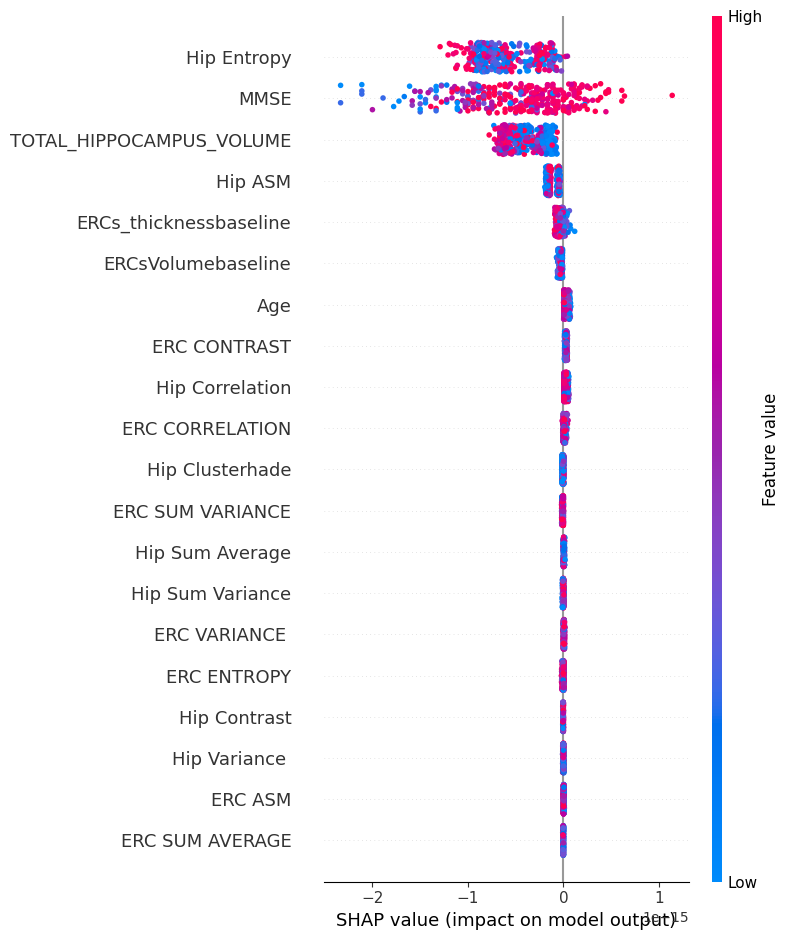

C:\Users\steve\AppData\Local\Temp\ipykernel_10772\903995680.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb_sum, X_test_t, feature_names=X_test_t.columns)


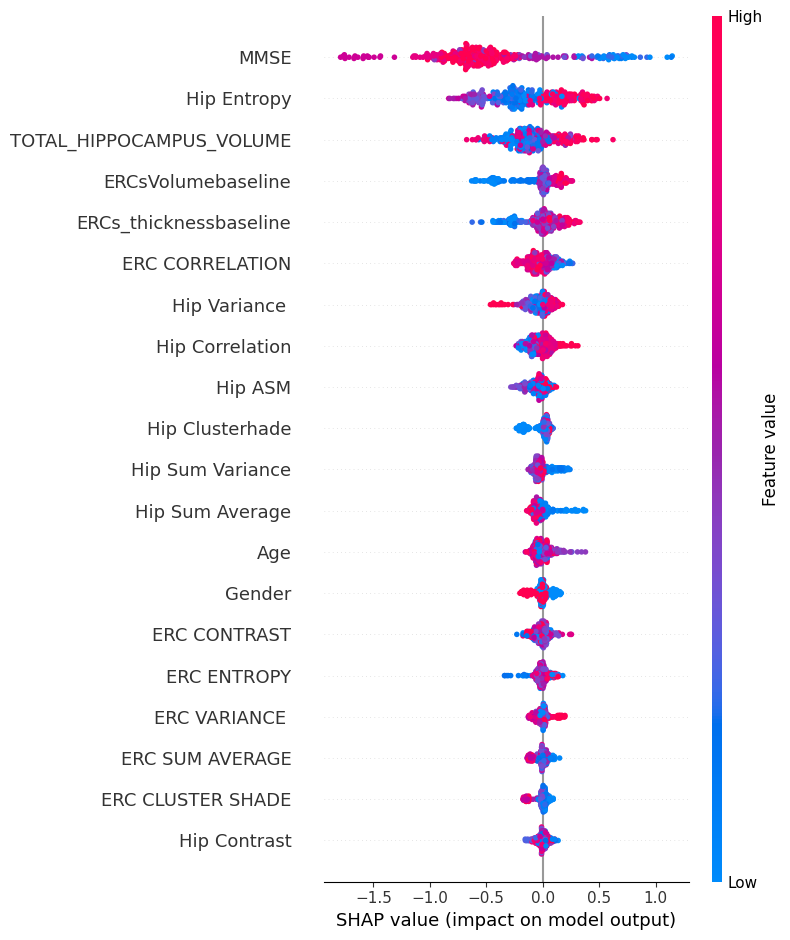

C:\Users\steve\AppData\Local\Temp\ipykernel_10772\903995680.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_ngb_sum, X_test_t, feature_names=X_test_t.columns)


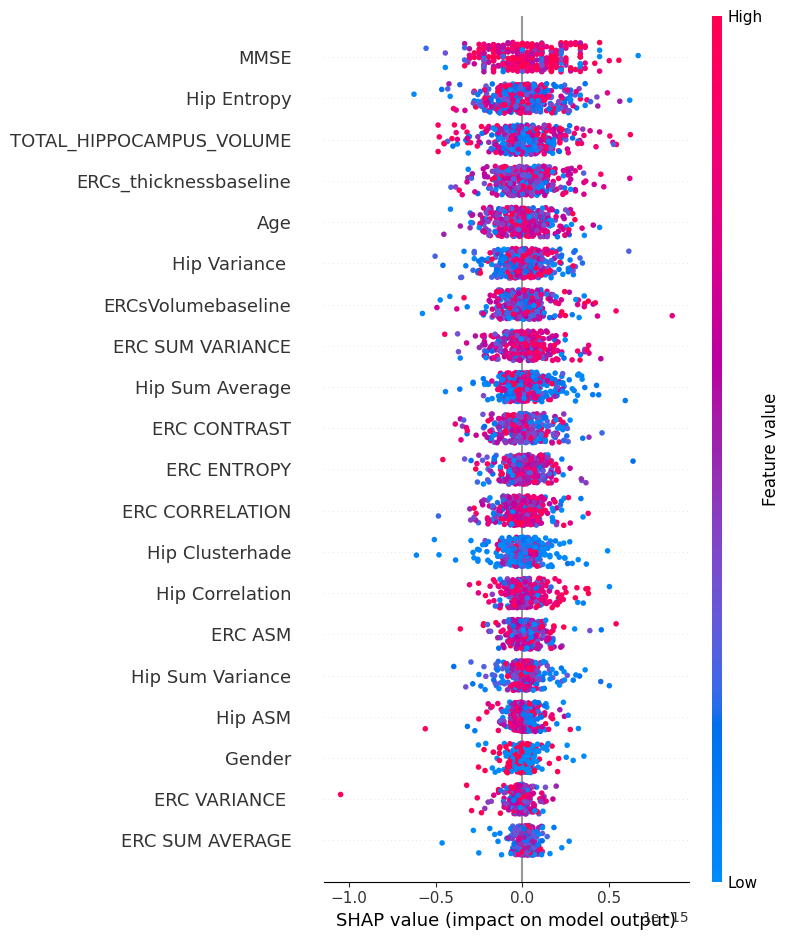

C:\Users\steve\AppData\Local\Temp\ipykernel_10772\903995680.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_logit_sum, X_test_t, feature_names=X_test_t.columns)


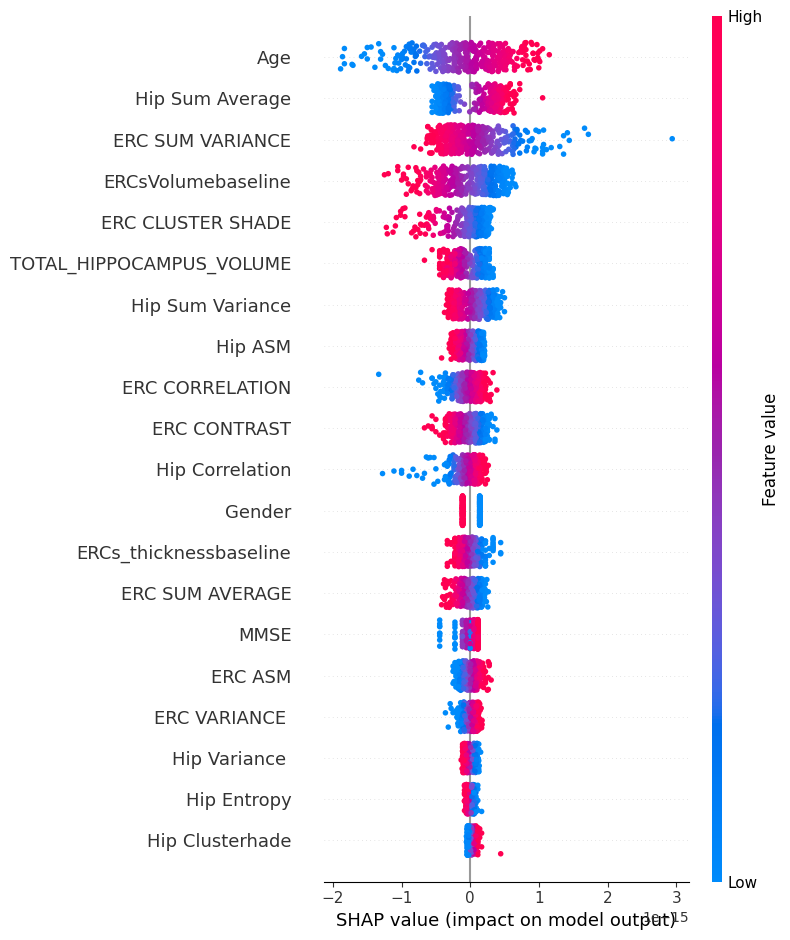

In [ ]:
shap_values_rf_sum = shap_values_rf.sum(axis=2)  # Sum over classes
shap_values_xgb_sum = shap_values_xgb.sum(axis=2)
shap_values_ngb_sum = shap_values_ngb.values.sum(axis=2)
shap_values_logit_sum = shap_values_logit.sum(axis=2)

# Plot the aggregated beeswarm plots
shap.summary_plot(shap_values_rf_sum, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_xgb_sum, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_ngb_sum, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_logit_sum, X_test_t, feature_names=X_test_t.columns)

In [ ]:
import matplotlib.pyplot as plt

# ---------------------
# Random Forest
# ---------------------
plt.figure()
shap.summary_plot(shap_values_rf_sum, X_test_t, feature_names=X_test_t.columns, show=False)
plt.title("Random Forest (Sum over classes in Merged)")
plt.tight_layout()
plt.show()

# ---------------------
# XGBoost
# ---------------------
plt.figure()
shap.summary_plot(shap_values_xgb_sum, X_test_t, feature_names=X_test_t.columns, show=False)
plt.title("XGBoost (Sum over classes in Merged)")
plt.tight_layout()
plt.show()

# ---------------------
# NGBoost
# ---------------------
plt.figure()
shap.summary_plot(shap_values_ngb_sum, X_test_t, feature_names=X_test_t.columns, show=False)
plt.title("NGBoost (Sum over classes in Merged)")
plt.tight_layout()
plt.show()

# ---------------------
# Logistic Regression
# ---------------------
plt.figure()
shap.summary_plot(shap_values_logit_sum, X_test_t, feature_names=X_test_t.columns, show=False)
plt.title("Logistic Regression (Sum over classes in Merged)")
plt.tight_layout()
plt.show()
